---
title: "SURVIVAL RATE ANALYSIS - UNSECURED PERSONAL LOAN PORTFOLIO"
---

## SURVIVAL RATE MODELING
### Analysis of Unsecured Personal Loan Portfolio Segemented by Credit Score, Rate and Original Loan Amount

This notebook demonstrates advanced survival analysis techniques using Kaplan-Meier and Cox regression models applied to unsecuredpersonal loan portfolio data. We progress from exploratory data analysis through univariate survival modeling to risk-adjusted survival estimates and competing risk analysis. Lastly, we'll compile findings for credit risk management and portfolio optimization applications.
Key Analyses:

1) Portfolio EDA and survival model readiness assessment

2) Kaplan-Meier survival estimation with censoring adjustments for young loans

3) Cox Proportional Hazards modeling with time-varying covariates

4) Credit risk management applications (PD modeling, portfolio segmentation, loss forecasting)

------------------------------------------------------------------------------------------------------

In [105]:
# Import Packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy import stats
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
## Front loading functions for later use

In [4]:
def bucket_loan_data(loan_data, col, bucket_col, bins, labels):
    """
    Bucket loan data into categories based on rate.
    """
    # Ensure 'rate' column exists
    if 'rate' not in loan_data.columns:
        raise ValueError("Data must contain 'rate' column for bucketing.")
    
    # Create buckets based on rate
    loan_data[bucket_col] = pd.cut(
                loan_data[col], 
                bins=bins, 
                labels=labels
    )
    return loan_data

In [5]:
def structure_loan_data(loan_data_csv):
    """
    Structure the raw loan data into a DataFrame with specific columns.
    """
    loan_data_raw = pd.read_csv(loan_data_csv)

    
    # Initialize dataframe for loan data
    loan_data = pd.DataFrame(columns=['loan_id', 'open_date', 'credit_score', '6_month_credit_score', 'rate', 'orig_amount', 'status', 'rate_bucket', 'score_bucket', 'orig_amount_bucket', 'open_year', 'open_month', 'open_month_str', 'maturity_date'])

    loan_data['loan_id'] = loan_data_raw.index + 1000
    loan_data['open_date'] = pd.to_datetime(loan_data_raw['OPEN_DATE'])
    loan_data['credit_score'] = loan_data_raw['CREDIT_SCORE_AT_ORIG']
    loan_data['6_month_score_change'] = loan_data_raw['6_MOS_SCORE_CHG']
    loan_data['rate'] = loan_data_raw['RATE']
    loan_data['orig_amount'] = loan_data_raw['LOAN_AMOUNT']
    loan_data['status'] = loan_data_raw['STATUS']

    # Randomly assign a amtuirty date between 3 and 8 years from the open date
    loan_data['maturity_date'] = loan_data['open_date'] + pd.to_timedelta(loan_data_raw['TERM'] * 30.44, unit='D')

    #Backfill other date columns
    loan_data['open_month'] = loan_data['open_date'].dt.to_period('M')
    loan_data['open_year'] = loan_data['open_date'].dt.year
    loan_data['open_month_str'] = loan_data['open_month'].astype(str)


    # Create buckets for rate
    rate_bucket_bins = [0, 5, 8, 12, 15, 22]
    rate_bucket_labels = ['Low', 'Low-Med', 'Medium', 'Med-High', 'High']
    loan_data = bucket_loan_data(loan_data, 'rate', 'rate_bucket',
                    bins=rate_bucket_bins,
                    labels=rate_bucket_labels
                    )

    # Create buckets for credit score
    score_bucket_bins=[0, 579,  619,  659, 719, 850]
    score_bucket_labels=['Deep Subprime', 'Subprime', 'Near-Prime', 'Prime', 'Super-Prime']
    loan_data = bucket_loan_data(loan_data, 'credit_score', 'score_bucket',
                    bins=score_bucket_bins,
                    labels=score_bucket_labels
                    )

    # Create buckets for orignal amount
    orig_amount_bucket_bins = [0, 5000, 10000, 20000, 30000, 50000]
    orig_amount_bucket_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    loan_data = bucket_loan_data(loan_data, 'orig_amount', 'orig_amount_bucket',
                    bins=orig_amount_bucket_bins,
                    labels=orig_amount_bucket_labels
                    )
    
    loan_data = loan_data[loan_data['rate'] > 0]
    loan_data = loan_data[loan_data['credit_score'] > 0 ]
    return loan_data

In [6]:
def correlation_analysis(loan_data):
        """Analyze correlations between key variables"""
        # Select numeric columns for correlation
        numeric_cols = ['credit_score', 'rate', 'orig_amount', 'open_year']
        corr_matrix = loan_data[numeric_cols].corr()
        
        # Create correlation heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
        ax.set_title('Correlation Matrix - Key Loan Variables', fontweight='bold')
        
        return fig, corr_matrix

## 1.0 Loan Portfolio Sumamry and Exploratory Data Analysis
### 1.1 Generate Simulated Loan Portfolio

In [7]:
loan_data = structure_loan_data('loan_data.csv')

In [9]:
# start of Fed rate increase simulation
mid_date = datetime(2022, 4, 1)

In [10]:
loan_data['rate_status'] = loan_data['open_date'].apply(lambda x: 'Pre-Fed Rate Increase' if x < mid_date else 'Post-Fed Rate Increase')

In [11]:
print("Loan data generated successfully.")

Loan data generated successfully.


In [12]:
print(f"Total Loans: {len(loan_data):,}")
print(f"Date Range: {loan_data['open_date'].min().strftime('%Y-%m-%d')} to {loan_data['open_date'].max().strftime('%Y-%m-%d')}")
print(f"Years Covered: {loan_data['open_year'].nunique()}")

Total Loans: 4,389
Date Range: 2021-02-01 to 2025-01-31
Years Covered: 5


#### Overview
This analysis utilizes a simulated personal loan portfolio designed to replicate realistic market conditions and lending patterns for survival analysis modeling. The dataset provides a robust foundation for examining loan performance, default behavior, and portfolio risk dynamics.

#### Loan Volume & Timing
- Total Loans Generated: 5,000
- Origination Period: January 1, 2019 – June 30, 2025
- Volume Distribution: Strategically weighted to reflect market conditions
- Higher origination volumes during low-rate environment (2019-2022)
- Reduced origination volumes post-rate increases (2022-2025)

#### Loan Terms & Structure
- Principal Amount Range: $1,000 – $50,000
- Maturity Terms: 3 to 8 years (variable by loan)
- Product Type: Unsecured personal loans with fixed rates and terms
- Amortization: Standard fixed-payment structure

#### Credit Risk Profile
- Credit Scores: Randomly distributed across realistic range (350-850)
- 6-Month Refresh Scores: Secondary credit score data point for risk monitoring
- Risk Segmentation: Natural distribution across credit quality spectrum

##### Rate Environment Stratification
The interest rate structure was strategically designed to mirror actual market conditions.

##### Pre-Rate Increase Period (2019 – April 2022):
- Lower base interest rates reflecting historical market conditions
- Higher loan origination volumes
- Inverse correlation maintained between credit scores and rates

##### Rate Increase Period (April 2022 – 2025):
- Progressive rate increases of 5-6 percentage points
- Gradual implementation over 18-24 months
- Corresponding reduction in loan origination volumes
- Maintained credit-risk pricing differentials

#### 1.2 Portfolio Summary and Review

In [13]:
print("\033[1mPortfolio summary statistics results are the following:\033[0m")
print(f"  Total Number of Loans: {len(loan_data):,}")
print(f"  Average Portfolio Rate: {loan_data['rate'].mean():.2f}%")
print(f"  Average Original Amount: ${int(loan_data['orig_amount'].mean()):,}")
print(f"  Average Credit Score: {int(loan_data['credit_score'].mean())}")

Portfolio summary statistics results are the following:
  Total Number of Loans: 4,389
  Average Portfolio Rate: 12.33%
  Average Original Amount: $13,997
  Average Credit Score: 721


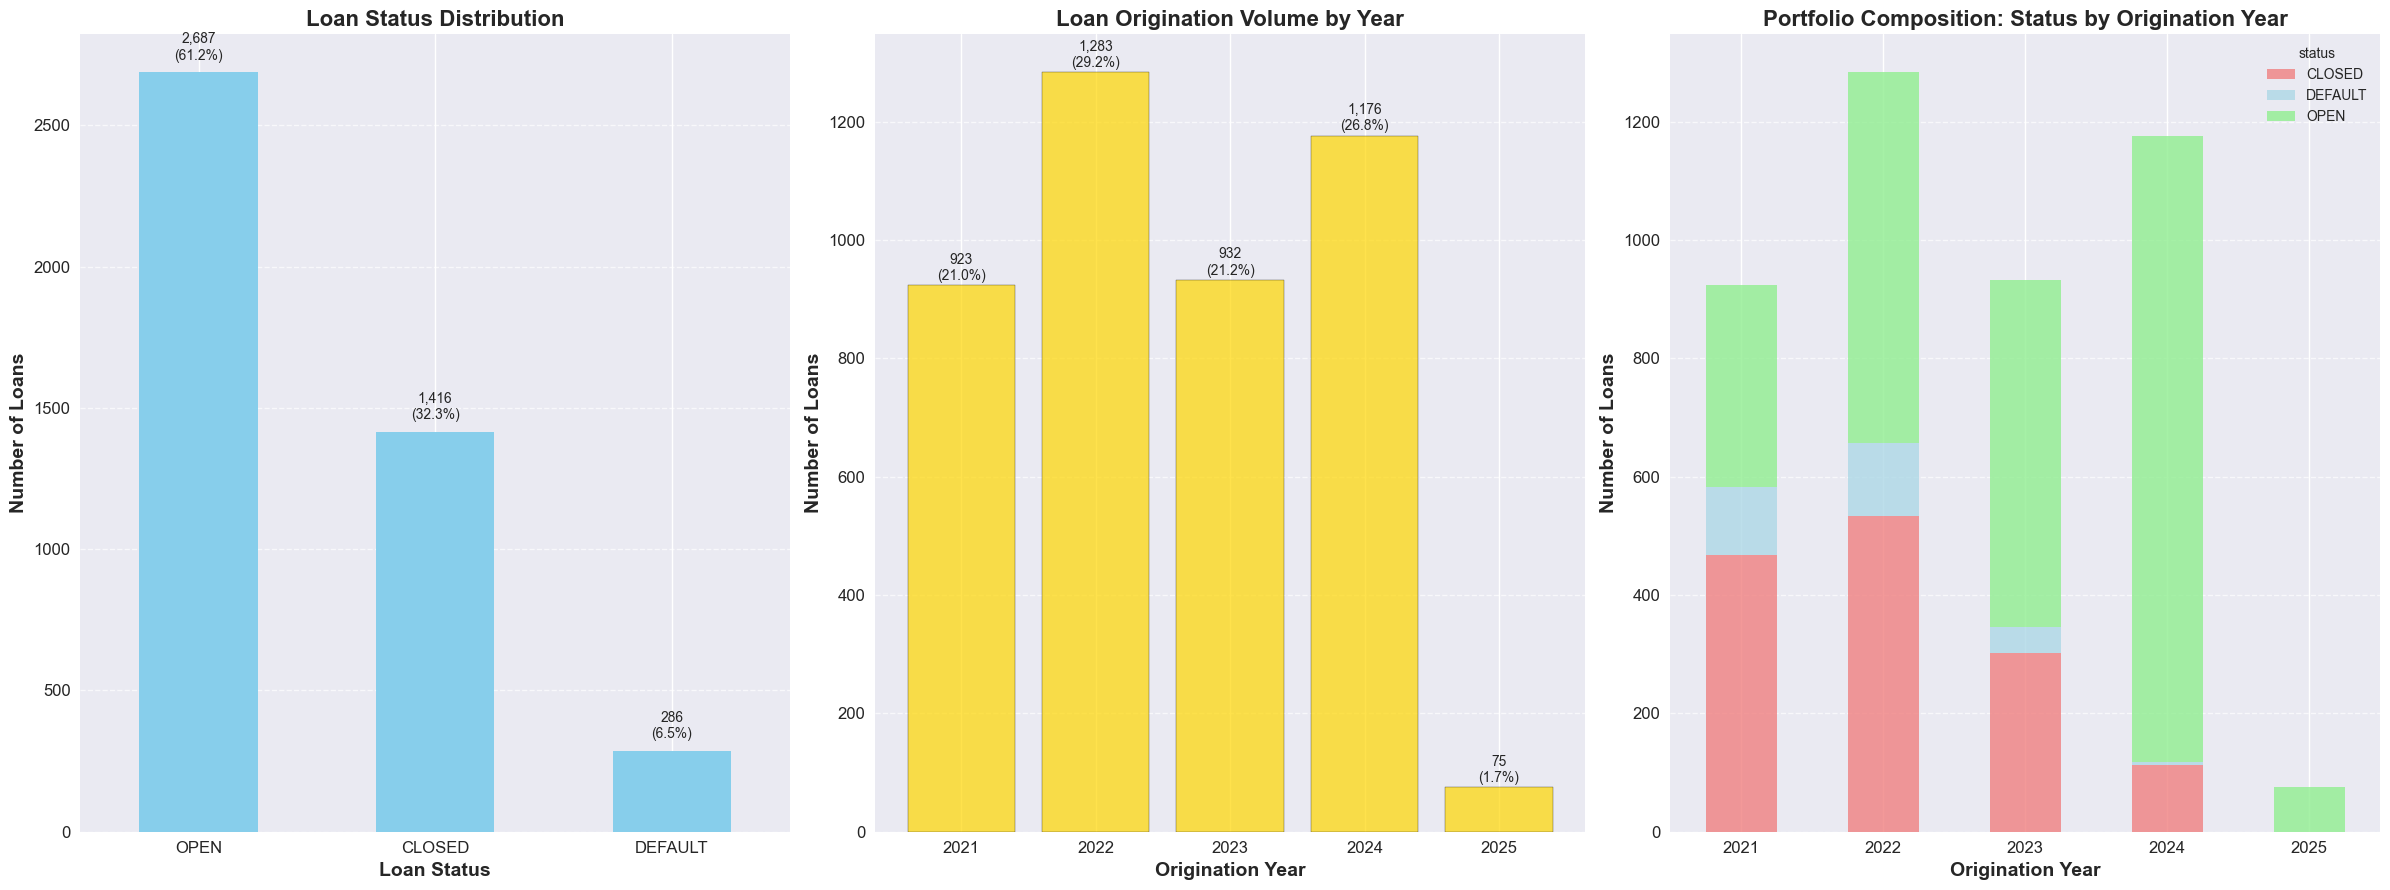

In [14]:
fig = plt.figure(figsize=(24, 9))

# Plot 1: Status Distribution
plt.subplot(1, 3, 1)
status_counts = loan_data['status'].value_counts()
bars1 = status_counts.plot(kind='bar', color='skyblue')
plt.title('Loan Status Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Loan Status', fontsize=14, fontweight='bold')
plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on bars
total_loans = status_counts.sum()
for i, v in enumerate(status_counts.values):
    plt.text(i, v + 0.008*total_loans, f'{v:,}\n({v/total_loans*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

# Plot 2: Yearly Volume
plt.subplot(1, 3, 2)
yearly_volume = loan_data.groupby('open_year').size()
years = yearly_volume.index.astype(str)  # Convert PeriodIndex to string for plotting
plt.bar(years, yearly_volume.values, alpha=0.7, color='gold', edgecolor='black')
plt.title('Loan Origination Volume by Year', fontsize=16, fontweight='bold')
plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

year_loans = yearly_volume.sum()
for i, v in enumerate(yearly_volume.values):
    plt.text(i, v + 0.001*year_loans, f'{v:,}\n({v/year_loans*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10)


# Plot 3: Status by Year
# Fix for third plot - use ax parameter
ax3 = plt.subplot(1, 3, 3)
status_by_year = loan_data.groupby(['open_year', 'status']).size().unstack(fill_value=0)
status_by_year.plot(kind='bar', stacked=True, alpha=0.8, 
                   color=['lightcoral', 'lightblue', 'lightgreen'], ax=ax3)
plt.title('Portfolio Composition: Status by Origination Year', fontsize=16, fontweight='bold')
plt.xlabel('Origination Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Loans', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Maybe add % open, closed, default, total by year as a table

#### 1.3 Key Metrics Summary by Credit Score, Rate, and Opening Amount

In [15]:
#Charts of distributions - Rate, Credit Score, Original Amount
#Charts showing scatter plots of rate vs credit score, rate vs original amount, and credit score vs original amount - colored by year
#Where does correlation chart exist?


In [ ]:
loan_data['duration_months'] = (
        (loan_data['observation_date'] - loan_data['open_date']).dt.days / 30.44
    ).round(2)

In [136]:
print("\nDEFAULT TIMING PATTERNS")
print("="*50)

# Vintage default performance
vintage_defaults = loan_data.groupby('open_year').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ],
    'duration_months': 'mean'
}).round(1)

print("Default rates by origination vintage:")
print(vintage_defaults)


DEFAULT TIMING PATTERNS
Default rates by origination vintage:
          status                       duration_months
           count <lambda_0> <lambda_1>            mean
open_year                                             
2021         923        114       12.4            43.3
2022        1283        123        9.6            31.3
2023         932         44        4.7            18.8
2024        1176          5        0.4             7.4
2025          75          0        0.0             0.5


In [137]:
print("DEFAULT RISK ANALYSIS BY KEY SEGMENTS")
print("="*50)

# Credit Score Default Rates
print("\n1. Default Rates by Credit Score Segment:")
credit_defaults = loan_data.groupby('score_bucket').agg({
    'status': [
        'count',
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
credit_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(credit_defaults)

# Rate Bucket Default Rates  
print("\n2. Default Rates by Interest Rate Segment:")
rate_defaults = loan_data.groupby('rate_bucket').agg({
    'status': [
        'count', 
        lambda x: (x == 'DEFAULT').sum(),
        lambda x: (x == 'DEFAULT').mean() * 100
    ]
}).round(1)
rate_defaults.columns = ['Total_Loans', 'Defaults', 'Default_Rate_%']
print(rate_defaults)

# Risk Differentiation Summary
print(f"\n3. Risk Differentiation:")
highest_risk = credit_defaults['Default_Rate_%'].max()
lowest_risk = credit_defaults['Default_Rate_%'].min()
print(f"   • Credit Score Risk Spread: {highest_risk - lowest_risk:.1f} percentage points")
print(f"   • Highest Risk Segment: {highest_risk:.1f}% default rate")
print(f"   • Lowest Risk Segment: {lowest_risk:.1f}% default rate")

DEFAULT RISK ANALYSIS BY KEY SEGMENTS

1. Default Rates by Credit Score Segment:
               Total_Loans  Defaults  Default_Rate_%
score_bucket                                        
Deep Subprime           49         9            18.4
Subprime                89         8             9.0
Near-Prime             482        73            15.1
Prime                 1654       144             8.7
Super-Prime           2033        50             2.5

2. Default Rates by Interest Rate Segment:
             Total_Loans  Defaults  Default_Rate_%
rate_bucket                                       
Low                    0         0             NaN
Low-Med                1         0             0.0
Medium              2318       153             6.6
Med-High            1591        92             5.8
High                 475        40             8.4

3. Risk Differentiation:
   • Credit Score Risk Spread: 15.9 percentage points
   • Highest Risk Segment: 18.4% default rate
   • Lowest Risk Segm

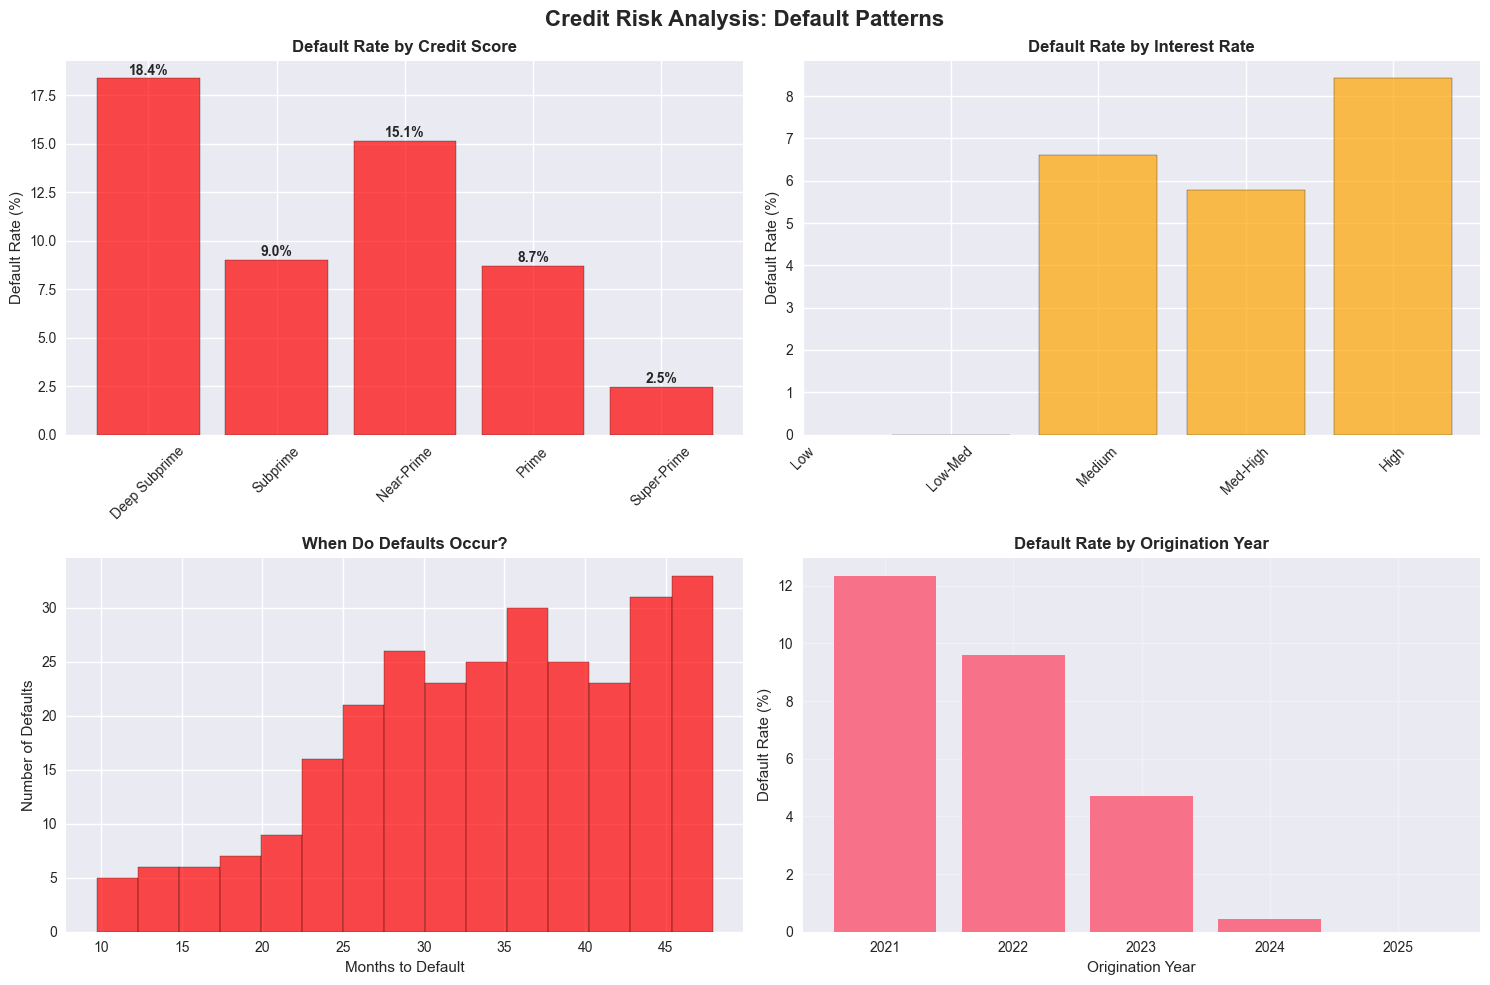

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Credit Risk Analysis: Default Patterns', fontsize=16, fontweight='bold')

# 1. Default Rate by Credit Score
ax1 = axes[0,0]
credit_default_rates = loan_data.groupby('score_bucket')['status'].apply(
    lambda x: (x == 'DEFAULT').mean() * 100
)
bars1 = ax1.bar(range(len(credit_default_rates)), credit_default_rates.values, 
                color='red', alpha=0.7, edgecolor='black')
ax1.set_title('Default Rate by Credit Score', fontweight='bold')
ax1.set_ylabel('Default Rate (%)')
ax1.set_xticks(range(len(credit_default_rates)))
ax1.set_xticklabels(credit_default_rates.index, rotation=45)

# Add value labels
for i, v in enumerate(credit_default_rates.values):
    ax1.text(i, v + 0.2, f'{v:.1f}%', ha='center', fontweight='bold')

# 2. Default Rate by Interest Rate
ax2 = axes[0,1] 
rate_default_rates = loan_data.groupby('rate_bucket')['status'].apply(
    lambda x: (x == 'DEFAULT').mean() * 100
)
bars2 = ax2.bar(range(len(rate_default_rates)), rate_default_rates.values,
                color='orange', alpha=0.7, edgecolor='black')
ax2.set_title('Default Rate by Interest Rate', fontweight='bold')
ax2.set_ylabel('Default Rate (%)')
ax2.set_xticks(range(len(rate_default_rates)))
ax2.set_xticklabels(rate_default_rates.index, rotation=45)

# 3. Default Timing Distribution
ax3 = axes[1,0]
defaulted_loans = loan_data[loan_data['status'] == 'DEFAULT']
ax3.hist(defaulted_loans['duration_months'], bins=15, alpha=0.7, 
         color='red', edgecolor='black')
ax3.set_title('When Do Defaults Occur?', fontweight='bold')
ax3.set_xlabel('Months to Default')
ax3.set_ylabel('Number of Defaults')

# 4. Default Rate by Vintage Year
ax4 = axes[1,1]
vintage_default_rates = loan_data.groupby('open_year')['status'].apply(
    lambda x: (x == 'DEFAULT').mean() * 100
)
ax4.bar(vintage_default_rates.index, vintage_default_rates.values)
ax4.set_title('Default Rate by Origination Year', fontweight='bold')
ax4.set_xlabel('Origination Year')
ax4.set_ylabel('Default Rate (%)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

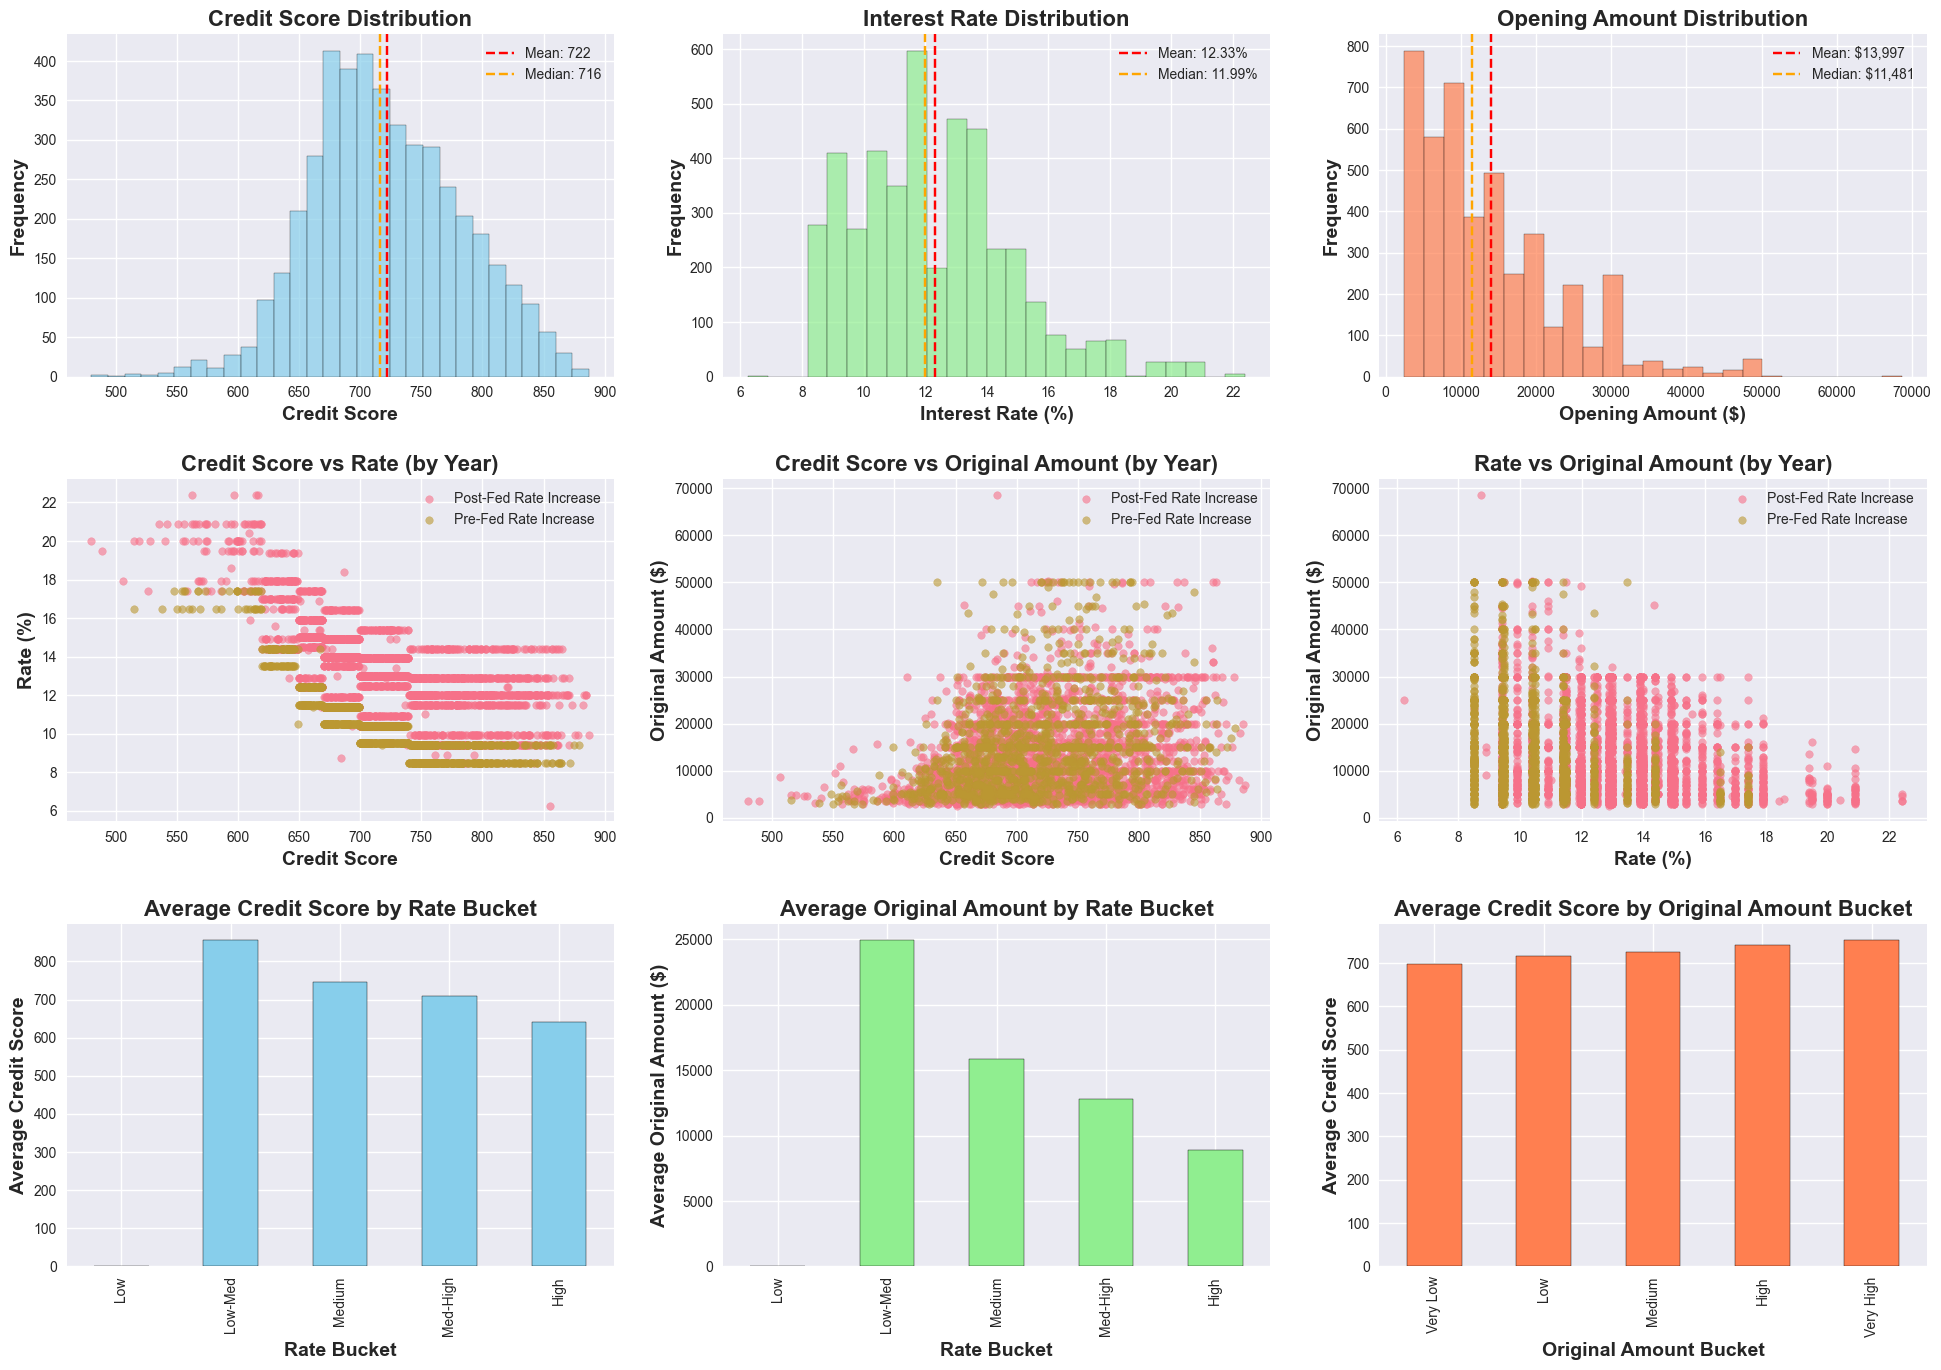

In [22]:
"""Plot distributions of key variables"""
fig = plt.figure(figsize=(24, 16))
#, axes = plt.subplots(2, 3, figsize=(12,10), sharex=False, sharey=True)
#fig.suptitle('Distribution Analysis - Personal Loan Portfolio', fontsize=16, fontweight='bold')
        
# Credit Score Distribution
plt.subplot(3,3,1)
plt.hist(loan_data['credit_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(loan_data['credit_score'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {loan_data["credit_score"].mean():.0f}')
plt.axvline(loan_data['credit_score'].median(), color='orange', linestyle='--',
                         label=f'Median: {loan_data["credit_score"].median():.0f}')
plt.title('Credit Score Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.legend()
        
# Interest Rate Distribution
plt.subplot(3,3,2)
plt.hist(loan_data['rate'], bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(loan_data['rate'].mean(), color='red', linestyle='--',
                         label=f'Mean: {loan_data["rate"].mean():.2f}%')
plt.axvline(loan_data['rate'].median(), color='orange', linestyle='--',
                         label=f'Median: {loan_data["rate"].median():.2f}%')
plt.title('Interest Rate Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Interest Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.legend()
        
# Loan Amount Distribution
plt.subplot(3,3,3)
plt.hist(loan_data['orig_amount'], bins=25, alpha=0.7, color='coral', edgecolor='black')
plt.axvline(loan_data['orig_amount'].mean(), color='red', linestyle='--',
                         label=f'Mean: ${loan_data["orig_amount"].mean():,.0f}')
plt.axvline(loan_data['orig_amount'].median(), color='orange', linestyle='--',
                         label=f'Median: ${loan_data["orig_amount"].median():,.0f}')
plt.title('Opening Amount Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Opening Amount ($)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.legend()

# Credit Score vs Rate
plt.subplot(3,3,4) 
for r_status in loan_data['rate_status'].unique():
            rate_status_data = loan_data[loan_data['rate_status'] == r_status]
            plt.scatter(rate_status_data['credit_score'], rate_status_data['rate'], 
                             alpha=0.6, label=f'{r_status}', s=30)
plt.title('Credit Score vs Rate (by Year)', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score', fontsize=14, fontweight='bold')
plt.ylabel('Rate (%)', fontsize=14, fontweight='bold')
plt.legend()

# Credit Score vs Original Amount
plt.subplot(3,3,5) 
for r_status in loan_data['rate_status'].unique():
            rate_status_data = loan_data[loan_data['rate_status'] == r_status]
            plt.scatter(rate_status_data['credit_score'], rate_status_data['orig_amount'], 
                             alpha=0.6, label=f'{r_status}', s=30)
plt.title('Credit Score vs Original Amount (by Year)', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score', fontsize=14, fontweight='bold')
plt.ylabel('Original Amount ($)', fontsize=14, fontweight='bold')
plt.legend()

# Rate vs Original Amount
plt.subplot(3,3,6) 
for r_status in loan_data['rate_status'].unique():
            rate_status_data = loan_data[loan_data['rate_status'] == r_status]
            plt.scatter(rate_status_data['rate'], rate_status_data['orig_amount'], 
                             alpha=0.6, label=f'{r_status}', s=30)
plt.title('Rate vs Original Amount (by Year)', fontsize=16, fontweight='bold')
plt.xlabel('Rate (%)', fontsize=14, fontweight='bold')
plt.ylabel('Original Amount ($)', fontsize=14, fontweight='bold')
plt.legend()

# Average Credit Score by Rate Bucket
plt.subplot(3,3,7)
avg_credit_score_by_rate = loan_data.groupby('rate_bucket')['credit_score'].mean().sort_index()
avg_credit_score_by_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Credit Score by Rate Bucket', fontsize=16, fontweight='bold')
plt.xlabel('Rate Bucket', fontsize=14, fontweight='bold')
plt.ylabel('Average Credit Score', fontsize=14, fontweight='bold')

# Average Original Amount by Rate Bucket
plt.subplot(3,3,8)
avg_orig_amount_by_rate = loan_data.groupby('rate_bucket')['orig_amount'].mean().sort_index()
avg_orig_amount_by_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Original Amount by Rate Bucket', fontsize=16, fontweight='bold')
plt.xlabel('Rate Bucket', fontsize=14, fontweight='bold')
plt.ylabel('Average Original Amount ($)', fontsize=14, fontweight='bold')

# Average Credit Score by Original Amount Bucket
plt.subplot(3,3,9)
avg_rate_by_score = loan_data.groupby('orig_amount_bucket')['credit_score'].mean().sort_index()
avg_rate_by_score.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Credit Score by Original Amount Bucket', fontsize=16, fontweight='bold')
plt.xlabel('Original Amount Bucket', fontsize=14, fontweight='bold')
plt.ylabel('Average Credit Score', fontsize=14, fontweight='bold')

plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Width space, Height space
plt.show()



Write a detailed summary about what I'm seeing in the data. May need to add another section on the Rate analysis

In [17]:
# Need to run a correlation matrix for all 5 years

(<Figure size 800x600 with 2 Axes>,
               credit_score      rate  orig_amount  open_year
 credit_score      1.000000 -0.594698     0.241114   0.055540
 rate             -0.594698  1.000000    -0.282567   0.492511
 orig_amount       0.241114 -0.282567     1.000000  -0.079866
 open_year         0.055540  0.492511    -0.079866   1.000000)

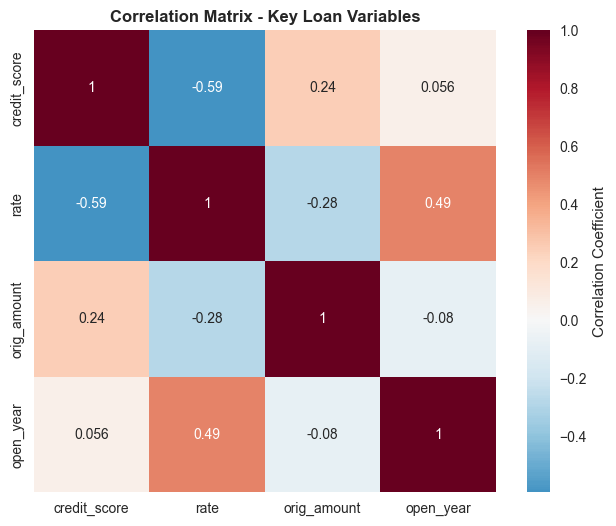

In [18]:
correlation_analysis(loan_data)

Write a short sumamry interpreting the correlations

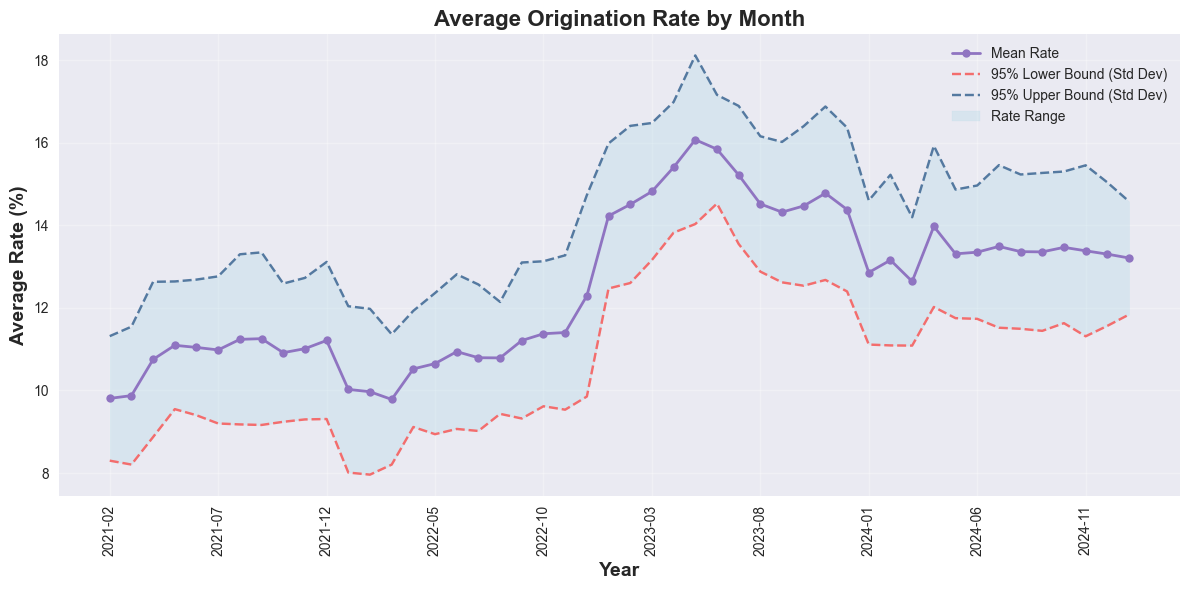

In [48]:
#average rate by month
#Personal Loan Rate Distributions and Origination Volume Over Time - candlestick layer on top?
#additional fig with loan origination volume by month

# Mean rate by year
plt.figure(figsize=(12, 6))
#yearly_max = loan_data.groupby('open_month_str')['rate'].max()
#plt.plot(yearly_max.index, yearly_max.values, linewidth=1, label='Max Rate')
#yearly_min = loan_data.groupby('open_month_str')['rate'].min() 
#plt.plot(yearly_min.index, yearly_min.values, linewidth=1, label='Min Rate')
#plt.fill_between(yearly_max.index, yearly_min.values, yearly_max.values, color='lightgray', alpha=0.5, label='Rate Range')

yearly_mean = loan_data.groupby('open_month_str')['rate'].mean()
yearly_std_lower = yearly_mean + (loan_data.groupby('open_month_str')['rate'].std()*1.96)/-2 #95% CI lower bound
yearly_std_upper = yearly_mean + (loan_data.groupby('open_month_str')['rate'].std()*1.96)/2 #95% CI upper bound

plt.plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, markersize=6, label='Mean Rate', color="#8f74c1")
plt.plot(yearly_std_lower.index, yearly_std_lower.values, linestyle='--', color="#f36d6d", label='95% Lower Bound (Std Dev)')
plt.plot(yearly_std_upper.index, yearly_std_upper.values, linestyle='--', color="#5479a0", label='95% Upper Bound (Std Dev)')
plt.fill_between(yearly_mean.index, yearly_std_lower.values, yearly_std_upper.values, color='lightblue', alpha=0.3, label='Rate Range')

plt.title('Average Origination Rate by Month', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Average Rate (%)', fontsize=14, fontweight='bold')
ticks = plt.xticks()[0]
labels = plt.xticks()[1]
plt.xticks(ticks[::5], [label.get_text() for label in labels[::5]], rotation=90)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Write a detailed summary of the data, observations and the path forward.

Is there something else I should add to analyze the defaulted loans? I looked at the portfolio, but what about loans that defaulted?

## 2.0 Kaplan-Meier Survival Rate Analysis

In [52]:
loan_data['event_target'] = loan_data['status'].apply(lambda x: 1 if x == 'Defaulted' else 0)
loan_data['observation_date'] = max(loan_data['open_date'])

Add a brief writeup of the appraoch. Focus on defaulted. Binary targets: 1 = defaulted, 0 = closed or open. using months as the unit of measurement.

#### 2.1 Baseline Kaplan-Meier Survival Rate Analysis

In [79]:
def prepare_survival_data(loan_data, observation_date=None):
    """
    Prepare loan data for survival analysis
    Focus: Time to Default (Approach 1)
    """
    
    # Set observation date if not provided
    if observation_date is None:
        observation_date = pd.Timestamp.now()
    else:
        observation_date = pd.to_datetime(observation_date, format='%m-%d-%Y')
    
    # Create a copy for survival analysis
    survival_data = loan_data.copy()
    
    # Define events: 1 = Default, 0 = Censored (Open or Closed)
    survival_data['event'] = (survival_data['status'] == 'DEFAULT').astype(int)
    
    # Calculate duration in months since origination
    survival_data['duration_months'] = (
        (observation_date - survival_data['open_date']).dt.days / 30.44
    ).round(2)
    
    # Basic validation
    print(f"  Observation Date: {observation_date.strftime('%Y-%m-%d')}")
    print(f"  Total Loans: {len(survival_data):,}")
    print(f"  Default Events: {survival_data['event'].sum():,} ({survival_data['event'].mean()*100:.1f}%)")
    print(f"  Censored Observations: {(1-survival_data['event']).sum():,} ({(1-survival_data['event']).mean()*100:.1f}%)")
    print(f"  Average Duration: {survival_data['duration_months'].mean():.1f} months")
    print(f"  Duration Range: {survival_data['duration_months'].min():.1f} to {survival_data['duration_months'].max():.1f} months")
    
    # Remove any negative durations (data quality issue)
    survival_data = survival_data[survival_data['duration_months'] >= 0]
    
    return survival_data

In [77]:
print("\033[1mBASELINE SURVIVAL ANALYSIS - DATA PREPARATION:\033[0m")

BASELINE SURVIVAL ANALYSIS - DATA PREPARATION:


In [80]:
survival_data = prepare_survival_data(loan_data, '01-31-2025')

  Observation Date: 2025-01-31
  Total Loans: 4,389
  Default Events: 286 (6.5%)
  Censored Observations: 4,103 (93.5%)
  Average Duration: 24.2 months
  Duration Range: 0.0 to 48.0 months


In [106]:
 # Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()
    
# Fit the survival curve
kmf.fit(durations=survival_data['duration_months'], 
            event_observed=survival_data['event'],
            label='Portfolio Baseline')

naf = NelsonAalenFitter()
naf.fit(survival_data['duration_months'], survival_data['event'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 4389 total observations, 4103 right-censored observations>

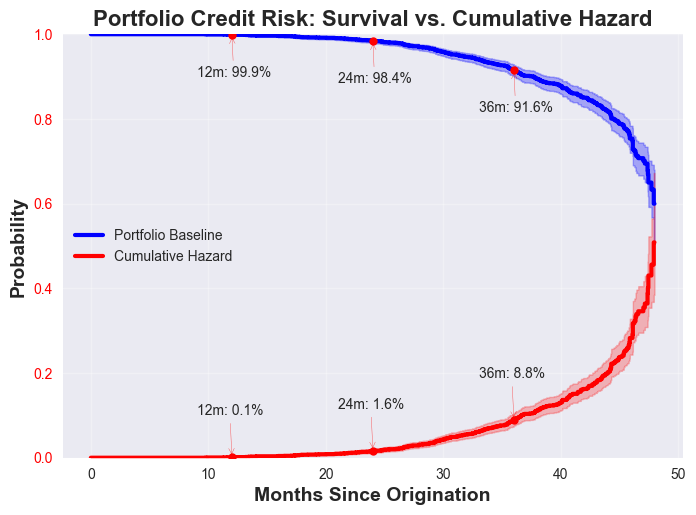

In [121]:
"""
Create comprehensive baseline survival visualization
"""
    
#fig, axes = plt.subplots(1, 1, figsize=(16, 12))
#fig.suptitle('Baseline Portfolio Survival Analysis', fontsize=18, fontweight='bold')
    
# Plot 1: Main survival curve with confidence intervals
plt.subplot(1,1,1)
kmf.plot_survival_function(ci_alpha=0.3, color='blue', linewidth=3)
plt.ylabel('Probability', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
# Add key survival milestones
key_times = [12, 24, 36]
for months in key_times:
    if months <= survival_data['duration_months'].max():
            survival_prob = kmf.survival_function_at_times(months).values[0]
            plt.plot(months, survival_prob, 'ro', markersize=6)
            plt.annotate(f'{months}m: {survival_prob:.1%}', 
                        xy=(months, survival_prob), 
                        xytext=(months-3, survival_prob - 0.1),
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                        fontsize=10, ha='left')

# Create second y-axis for cumulative hazard

naf.plot_cumulative_hazard(color='red', linewidth=3, label='Cumulative Hazard')
plt.tick_params(axis='y', labelcolor='red')
plt.title('Portfolio Credit Risk: Survival vs. Cumulative Hazard', fontsize=16, fontweight='bold')
plt.xlabel('Months Since Origination', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
# Add key survival milestones
key_times = [12, 24, 36]
for months in key_times:
    if months <= survival_data['duration_months'].max():
            survival_prob = naf.cumulative_hazard_at_times(months).values[0]
            plt.plot(months, survival_prob, 'ro', markersize=6)
            plt.annotate(f'{months}m: {survival_prob:.1%}', 
                        xy=(months, survival_prob), 
                        xytext=(months-3, survival_prob + 0.1),
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                        fontsize=10, ha='left')
plt.show()

In [123]:
def generate_survival_statistics(kmf, survival_data):
    """
    Generate key survival statistics and business metrics
    """
    
    stats = {}
    
    print(f"\n📊 BASELINE SURVIVAL STATISTICS")
    print("-" * 40)
    
    # Key time points for business analysis
    time_points = [6, 12, 18, 24, 30, 36]
    
    print(f"Survival Probabilities at Key Time Points:")
    for months in time_points:
        if months <= survival_data['duration_months'].max():
            survival_prob = kmf.survival_function_at_times(months).values[0]
            default_prob = 1 - survival_prob
            
            # Get confidence intervals - safer approach
            try:
                ci = kmf.confidence_interval_survival_function_
                # Find the closest time point
                time_diffs = (ci.index - months).abs()
                closest_idx = time_diffs.idxmin()
                
                # Extract CI bounds using the label from the KMF
                label = kmf._label or 'Portfolio Baseline'
                ci_lower = ci.loc[closest_idx, f'{label}_lower_0.95']
                ci_upper = ci.loc[closest_idx, f'{label}_upper_0.95']
                
                stats[f'{months}_month_ci_lower'] = ci_lower
                stats[f'{months}_month_ci_upper'] = ci_upper
                
                print(f"  {months:2d} months: {survival_prob:.1%} survival ({default_prob:.1%} default rate)")
                print(f"              95% CI: [{ci_lower:.1%}, {ci_upper:.1%}]")
                
            except (KeyError, AttributeError):
                # Fallback if CI calculation fails
                stats[f'{months}_month_ci_lower'] = None
                stats[f'{months}_month_ci_upper'] = None
                
                print(f"  {months:2d} months: {survival_prob:.1%} survival ({default_prob:.1%} default rate)")
                print(f"              95% CI: [Not available]")
            
            stats[f'{months}_month_survival'] = survival_prob
            stats[f'{months}_month_default'] = default_prob
        else:
            print(f"  {months:2d} months: Insufficient data (max duration: {survival_data['duration_months'].max():.1f} months)")
    
    # Median survival time (if enough events occurred)
    try:
        median_survival = kmf.median_survival_time_
        if not np.isnan(median_survival):
            stats['median_survival_months'] = median_survival
            print(f"\nMedian Time to Default: {median_survival:.1f} months")
        else:
            print(f"\nMedian Time to Default: Not reached (>50% survival)")
            stats['median_survival_months'] = None
    except:
        print(f"\nMedian Time to Default: Cannot be calculated")
        stats['median_survival_months'] = None
    
    # Portfolio risk metrics
    current_default_rate = survival_data['event'].mean()
    observation_period = survival_data['duration_months'].mean()
    
    stats['portfolio_default_rate'] = current_default_rate
    stats['average_observation_months'] = observation_period
    
    print(f"\n📈 PORTFOLIO RISK METRICS")
    print("-" * 40)
    print(f"Overall Default Rate: {current_default_rate:.1%}")
    print(f"Average Observation Period: {observation_period:.1f} months")
    
    # Annualized default rate estimation
    if observation_period > 0:
        annualized_default_rate = current_default_rate * (12 / observation_period)
        stats['annualized_default_rate'] = annualized_default_rate
        print(f"Estimated Annualized Default Rate: {annualized_default_rate:.1%}")
    
    return stats

def baseline_survival_summary(survival_stats):
    """
    Generate executive summary of baseline survival analysis
    """
    
    print("\n" + "="*60)
    print("📋 EXECUTIVE SUMMARY - BASELINE SURVIVAL ANALYSIS")
    print("="*60)
    
    # Key headline metrics
    if '12_month_survival' in survival_stats:
        print(f"🎯 Key Performance Indicators:")
        print(f"   • 12-Month Survival Rate: {survival_stats['12_month_survival']:.1%}")
        print(f"   • 12-Month Default Rate: {survival_stats['12_month_default']:.1%}")
        
    if '24_month_survival' in survival_stats:
        print(f"   • 24-Month Survival Rate: {survival_stats['24_month_survival']:.1%}")
        print(f"   • 24-Month Default Rate: {survival_stats['24_month_default']:.1%}")
    
    # Portfolio health metrics
    print(f"\n📊 Portfolio Health:")
    print(f"   • Overall Default Rate: {survival_stats['portfolio_default_rate']:.1%}")
    print(f"   • Average Observation: {survival_stats['average_observation_months']:.1f} months")
    
    if 'annualized_default_rate' in survival_stats:
        print(f"   • Estimated Annual Default Rate: {survival_stats['annualized_default_rate']:.1%}")
    
    # Risk insights
    print(f"\n🔍 Key Insights:")
    if survival_stats.get('median_survival_months'):
        print(f"   • Median time to default: {survival_stats['median_survival_months']:.1f} months")
    else:
        print(f"   • Median time to default: Not reached (majority of loans survive)")
    
    print(f"   • Portfolio demonstrates {'strong' if survival_stats['12_month_survival'] > 0.9 else 'moderate'} credit performance")
    
    # Next steps
    print(f"\n🚀 Next Steps:")
    print(f"   • Segment analysis by credit score buckets")
    print(f"   • Compare pre/post rate environment performance")
    print(f"   • Risk-adjusted survival modeling")

In [124]:
survival_stats = generate_survival_statistics(kmf, survival_data)
baseline_survival_summary(survival_stats)


📊 BASELINE SURVIVAL STATISTICS
----------------------------------------
Survival Probabilities at Key Time Points:
   6 months: 100.0% survival (0.0% default rate)
              95% CI: [Not available]
  12 months: 99.9% survival (0.1% default rate)
              95% CI: [Not available]
  18 months: 99.3% survival (0.7% default rate)
              95% CI: [Not available]
  24 months: 98.4% survival (1.6% default rate)
              95% CI: [Not available]
  30 months: 95.8% survival (4.2% default rate)
              95% CI: [Not available]
  36 months: 91.6% survival (8.4% default rate)
              95% CI: [Not available]

Median Time to Default: inf months

📈 PORTFOLIO RISK METRICS
----------------------------------------
Overall Default Rate: 6.5%
Average Observation Period: 24.2 months
Estimated Annualized Default Rate: 3.2%

📋 EXECUTIVE SUMMARY - BASELINE SURVIVAL ANALYSIS
🎯 Key Performance Indicators:
   • 12-Month Survival Rate: 99.9%
   • 12-Month Default Rate: 0.1%
   • 24-M